<a href="https://colab.research.google.com/github/divyani95/Forecast_Production/blob/main/Forcasted_Production(Random_forest_regressor).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load dataset
file_path = "/content/Total production till date - 290125.XLSX"
df = pd.read_excel(file_path, sheet_name='Sheet1')

In [18]:
# Drop irrelevant columns
columns_to_drop = [
    "Purchase Order", "Order Price Unit", "Special Stock", "Asset", "WBS Element",
    "Consumption", "Cost Center", "Customer", "Receipt Indicator", "Reason for Movement",
    "Document Header Text", "Reference", "Time of Entry", "Counter", "Currency",
    "Debit/Credit Ind.", "Item", "Item No.Stock Transfer Reserv.", "Material Doc. Year", "Reservation"
    ]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

In [19]:
# Convert Posting Date to datetime
df["Posting Date"] = pd.to_datetime(df["Posting Date"])

In [20]:
# Aggregate production quantity by date
df_daily = df.groupby("Posting Date")["Qty in Un. of Entry"].sum().reset_index()
df_daily = df_daily.sort_values("Posting Date")

In [21]:
# Create lag features for better predictions
for lag in range(1, 8):  # Using past 7 days as features
    df_daily[f"Lag_{lag}"] = df_daily["Qty in Un. of Entry"].shift(lag)

In [22]:
# Drop NaN values due to shifting
df_daily = df_daily.dropna()

In [23]:
# Create a time index
df_daily["Day"] = np.arange(len(df_daily))

In [24]:
# Split data into training and testing
train_size = int(len(df_daily) * 0.8)
train, test = df_daily.iloc[:train_size], df_daily.iloc[train_size:]
X_train = train[["Day"] + [f"Lag_{lag}" for lag in range(1, 8)]]
y_train = train["Qty in Un. of Entry"]
X_test = test[["Day"] + [f"Lag_{lag}" for lag in range(1, 8)]]
y_test = test["Qty in Un. of Entry"]

In [25]:
# Train Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [27]:
# Predict next 30 days iteratively
future_predictions = []
future_days = np.arange(len(df_daily), len(df_daily) + 30)
last_known_values = df_daily.iloc[-7:]["Qty in Un. of Entry"].values.tolist()
for day in future_days:
    input_features = [day] + last_known_values[-7:]
    predicted_qty = model.predict([input_features])[0]
    future_predictions.append(predicted_qty)
    last_known_values.append(predicted_qty)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

In [30]:
# Generate future dates
last_date = df_daily["Posting Date"].max()
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, 31)]

In [29]:
# Create forecast DataFrame
df_forecast = pd.DataFrame({"Posting Date": future_dates, "Predicted Qty": future_predictions})

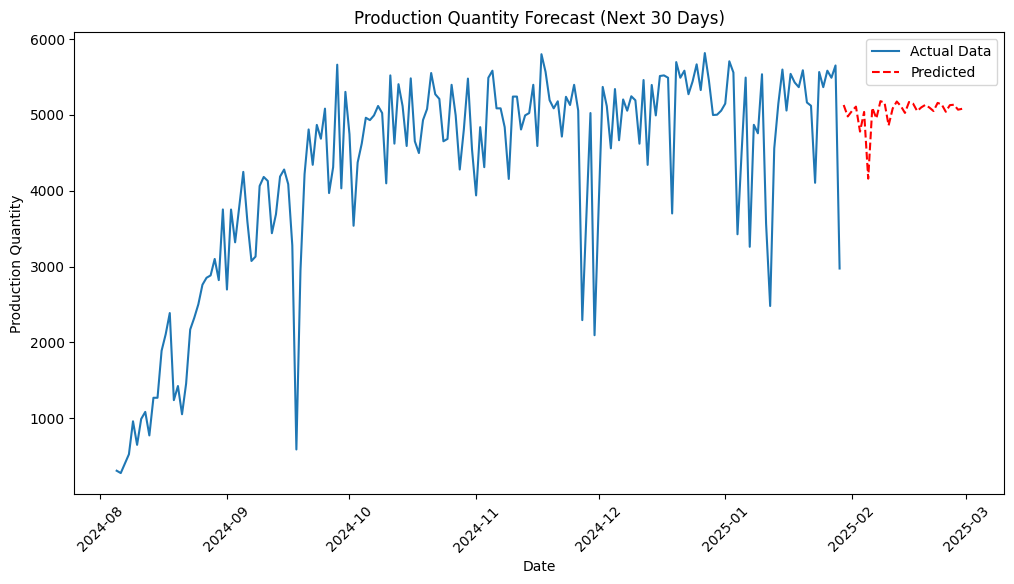

In [31]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df_daily["Posting Date"], df_daily["Qty in Un. of Entry"], label="Actual Data")
plt.plot(future_dates, future_predictions, label="Predicted", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Production Quantity")
plt.title("Production Quantity Forecast (Next 30 Days)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [32]:
# Save predictions to CSV
df_forecast.to_csv("production_forecast.csv", index=False)
print("Forecast saved as production_forecast.csv")

Forecast saved as production_forecast.csv
